In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_recall_fscore_support,precision_score, recall_score, 
                           confusion_matrix, accuracy_score,
                           f1_score, balanced_accuracy_score,
                           matthews_corrcoef,confusion_matrix)
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
import numpy as np

df1 = pd.read_csv("dataset/Physical dataset/phy_att_1.csv", sep="\t", encoding="utf-16")
df2 = pd.read_csv("dataset/Physical dataset/phy_att_2.csv", sep="\t", encoding="utf-16")
df3 = pd.read_csv("dataset/Physical dataset/phy_att_3.csv", sep="\t", encoding="utf-16")
df4 = pd.read_csv("dataset/Physical dataset/phy_att_4.csv", sep=",", encoding="utf-8")
df5 = pd.read_csv("dataset/Physical dataset/phy_norm.csv", sep="\t", encoding="utf-16")

df1.drop("Label_n",inplace=True,axis=1)
df2.drop("Lable_n",inplace=True,axis=1)
df3.drop("Label_n",inplace=True,axis=1)

# merge all datasets vertically
df = pd.concat([df1, df2, df3, df4, df5], axis=0)

df.drop("Time", inplace=True, axis=1)

# replace 'nomal' column to 'normal'
df["Label"] = df["Label"].apply(lambda x: "normal" if x == "nomal" else x)

# drop lines where label is "scan"
df = df[df["Label"] != "scan"]

                  Time  Tank_1  Tank_2  Tank_3  Tank_4  Tank_5  Tank_6  \
0  09/04/2021 18:23:28       0       0       0       0       0       0   
1  09/04/2021 18:23:29       0       0       0       0       0       0   
2  09/04/2021 18:23:30       0       0       0       0       0       0   
3  09/04/2021 18:23:31       0       0       0       0       0       0   
4  09/04/2021 18:23:32       0       0       0       0       0       0   

   Tank_7  Tank_8  Pump_1  ...  Valv_15  Valv_16  Valv_17  Valv_18  Valv_19  \
0       0       0   False  ...    False    False    False    False    False   
1       0       0   False  ...    False    False    False    False    False   
2       0       0   False  ...    False    False    False    False    False   
3       0       0   False  ...    False    False    False    False    False   
4       0       0    True  ...    False    False    False    False    False   

   Valv_20  Valv_21  Valv_22   Label  Label_n  
0    False    False    False  no

In [5]:
# 1 if Label is not 'normal' else 0

df["Label_n"] = df["Label"].apply(lambda x: 1 if x != "normal" else 0)

# shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,Tank_1,Tank_2,Tank_3,Tank_4,Tank_5,Tank_6,Tank_7,Tank_8,Pump_1,Pump_2,...,Valv_15,Valv_16,Valv_17,Valv_18,Valv_19,Valv_20,Valv_21,Valv_22,Label,Label_n
0,1726,1106,858,95,351,0,0,278,False,False,...,True,False,True,False,False,False,False,True,normal,0
1,739,994,914,33,0,330,458,40,False,True,...,False,False,True,False,False,False,False,False,normal,0
2,1848,1871,358,0,199,0,305,482,False,False,...,False,False,True,False,False,True,False,True,normal,0
3,1229,289,1238,31,766,0,168,462,False,False,...,False,False,True,False,False,False,False,True,MITM,1
4,272,5,925,1012,575,247,0,156,False,False,...,True,False,False,True,False,True,False,True,MITM,1


In [6]:
# print the number of different values for each column
# print only the cols with 1 unique value
print(df.nunique()[df.nunique() == 1])

# remove the cols with 1 unique value
df.drop(columns=df.nunique()[df.nunique() == 1].index, inplace=True)


Pump_3           1
Flow_sensor_3    1
Valv_1           1
Valv_2           1
Valv_3           1
Valv_4           1
Valv_5           1
Valv_6           1
Valv_7           1
Valv_8           1
Valv_9           1
Valv_16          1
Valv_19          1
Valv_21          1
dtype: int64


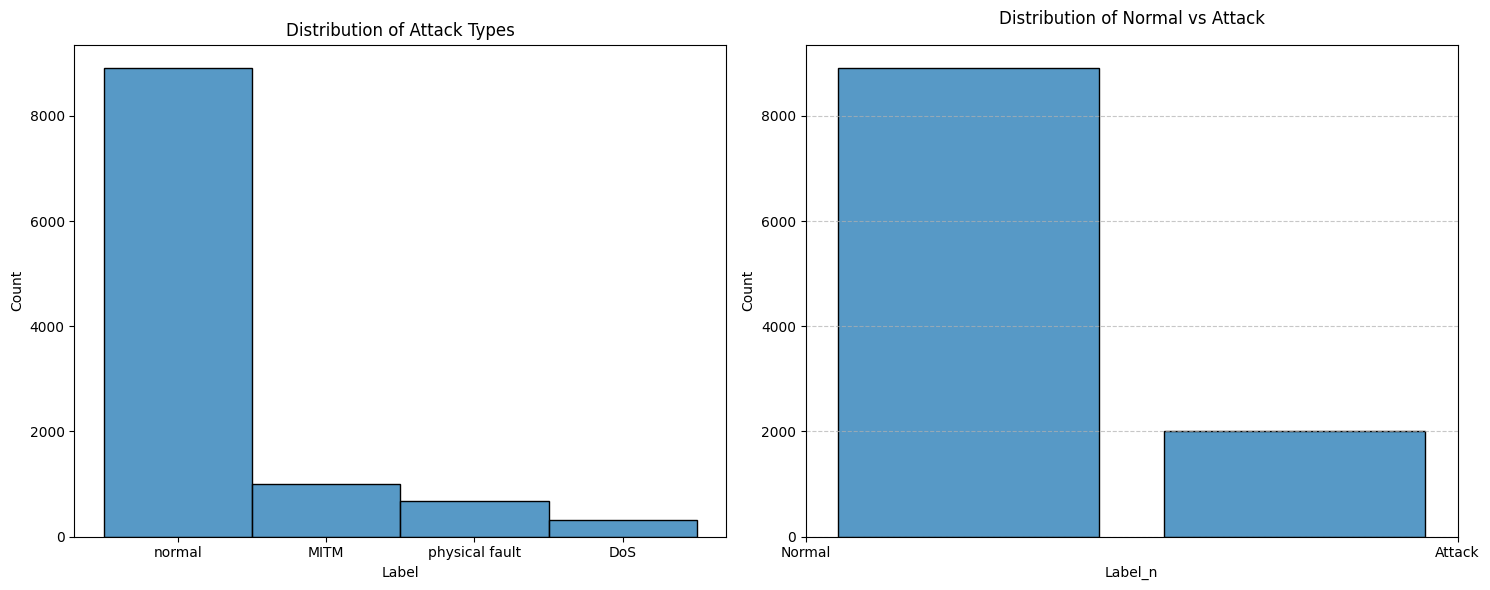

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Label distribution
sns.histplot(data=df, x='Label', ax=ax1)
ax1.set_title('Distribution of Attack Types')

# Plot Label_n distribution with improved style
sns.histplot(data=df, x='Label_n', ax=ax2, bins=2, stat='count', 
             shrink=0.8, edgecolor='black')
ax2.set_title('Distribution of Normal vs Attack', pad=15, fontsize=12)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Normal', 'Attack'], fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import time
from pprint import pprint

# Prepare data
target = "Label"
X = df.drop(["Label", "Label_n"], axis=1)
y = df[target]

possible_outputs = df[target].unique()

# Define models to test
models = {
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'CART': DecisionTreeClassifier(random_state=15),
    'Random Forest': RandomForestClassifier(random_state=15, n_estimators=100),
    # 'XGBoost': XGBClassifier(random_state=15),
    'CatBoost': CatBoostClassifier(random_state=15, verbose=False),
    "SVM": SVC(random_state=15, kernel="rbf"),
    "Naive Bayes": GaussianNB()
}

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=15)

for model_name, model in models.items():
    # Initialize lists to store metrics
    metrics = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    start = time.time()
    
    # Perform k-fold cross validation
    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train and evaluate model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        # pprint(report)
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(report['macro avg']['precision'])
        metrics['recall'].append(report['macro avg']['recall'])
        metrics['f1'].append(report['macro avg']['f1-score'])

    # Print results
    print(f"\nModel: {model_name} ran on {len(metrics['accuracy'])} folds in {time.time() - start:.2f} seconds")
    for metric in metrics:
        print(f'Average {metric.title()}(macro avg): {np.mean(metrics[metric]):.2f} ± {np.std(metrics[metric]):.2f}')


Model: KNN ran on 5 folds in 2.70 seconds
Average Accuracy(macro avg): 0.97 ± 0.00
Average Precision(macro avg): 0.93 ± 0.01
Average Recall(macro avg): 0.95 ± 0.01
Average F1(macro avg): 0.94 ± 0.01

Model: CART ran on 5 folds in 0.60 seconds
Average Accuracy(macro avg): 0.97 ± 0.00
Average Precision(macro avg): 0.95 ± 0.01
Average Recall(macro avg): 0.95 ± 0.01
Average F1(macro avg): 0.95 ± 0.01

Model: Random Forest ran on 5 folds in 5.19 seconds
Average Accuracy(macro avg): 0.98 ± 0.00
Average Precision(macro avg): 0.98 ± 0.01
Average Recall(macro avg): 0.96 ± 0.01
Average F1(macro avg): 0.97 ± 0.01

Model: CatBoost ran on 5 folds in 42.27 seconds
Average Accuracy(macro avg): 0.98 ± 0.00
Average Precision(macro avg): 0.97 ± 0.01
Average Recall(macro avg): 0.96 ± 0.01
Average F1(macro avg): 0.97 ± 0.00

Model: SVM ran on 5 folds in 10.89 seconds
Average Accuracy(macro avg): 0.86 ± 0.00
Average Precision(macro avg): 0.93 ± 0.03
Average Recall(macro avg): 0.45 ± 0.02
Average F1(macro 